In [8]:
import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.optimizers import SGD

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
train_path = 'Training'
test_path = 'Test'

In [59]:
from keras.preprocessing.image import ImageDataGenerator
# create a data generator
data_gen = ImageDataGenerator(rescale=1./255)
# load and iterate train dataset
train_set = data_gen.flow_from_directory(directory=train_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                       batch_size=256, subset='training')
test_set = data_gen.flow_from_directory(directory=test_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                      batch_size=256)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Sau khi load dữ liệu qua method flow_from_directory những điều cần lưu ý:

Hình màu thì set: color_mode="rgb"

Để class_mode='categorical' tức là nó đã one hot encode phần label (y)

Phương thức này load dữ liệu qua batch_size. Ở đây là batch_size=256 tức là ở mỗi mini batches có 256 hình.


In [60]:
print(train_set.image_shape)
print(test_set.image_shape)

(100, 100, 3)
(100, 100, 3)


In [43]:
path = train_path
label_list= os.listdir(os.path.expanduser(path)) # lấy list các nhãn
new_dic = {}
for label in label_list:
  num= os.listdir(os.path.expanduser(os.path.join(path, label))) # nối path và lấy list các item trong đó
  new_dic[label] = len(num) # thêm vào dictionary
new_dic

{'Tomato 4': 479,
 'Apple Red Delicious': 490,
 'Tomato 3': 738,
 'Huckleberry': 490,
 'Blueberry': 462,
 'Pear Red': 666,
 'Banana Lady Finger': 450,
 'Melon Piel de Sapo': 738,
 'Pear': 492,
 'Cherry 1': 492,
 'Strawberry': 492,
 'Nut Forest': 654,
 'Avocado': 427,
 'Tomato 2': 672,
 'Pomegranate': 492,
 'Dates': 490,
 'Carambula': 490,
 'Potato Red Washed': 453,
 'Granadilla': 490,
 'Kohlrabi': 471,
 'Tamarillo': 490,
 'Pepper Red': 666,
 'Fig': 702,
 'Ginger Root': 297,
 'Kiwi': 466,
 'Cherry Wax Yellow': 492,
 'Lemon': 492,
 'Guava': 490,
 'Apple Golden 2': 492,
 'Pear Stone': 711,
 'Apple Red 1': 492,
 'Cauliflower': 702,
 'Mandarine': 490,
 'Quince': 490,
 'Strawberry Wedge': 738,
 'Pear Monster': 490,
 'Raspberry': 490,
 'Pitahaya Red': 490,
 'Nut Pecan': 534,
 'Apple Golden 3': 481,
 'Redcurrant': 492,
 'Apple Red Yellow 1': 492,
 'Pepper Yellow': 666,
 'Grape Pink': 492,
 'Banana Red': 490,
 'Cucumber Ripe 2': 468,
 'Physalis': 492,
 'Cherry Rainier': 738,
 'Maracuja': 490,
 

In [44]:
# Tạo DataFrame từ dictionary
import pandas as pd
data = pd.DataFrame({'fruit_name': list(new_dic.keys()),
                    'number': list(new_dic.values())})

data.sort_values(by='number',ascending=False)

,fruit_name,number
107,Grape Blue,984
94,Plum 3,900
2,Tomato 3,738
47,Cherry Rainier,738
63,Cherry 2,738
...,...,...
52,Cucumber Ripe,392
69,Tomato Maroon,367
61,Pear Kaiser,300
62,Mangostan,300


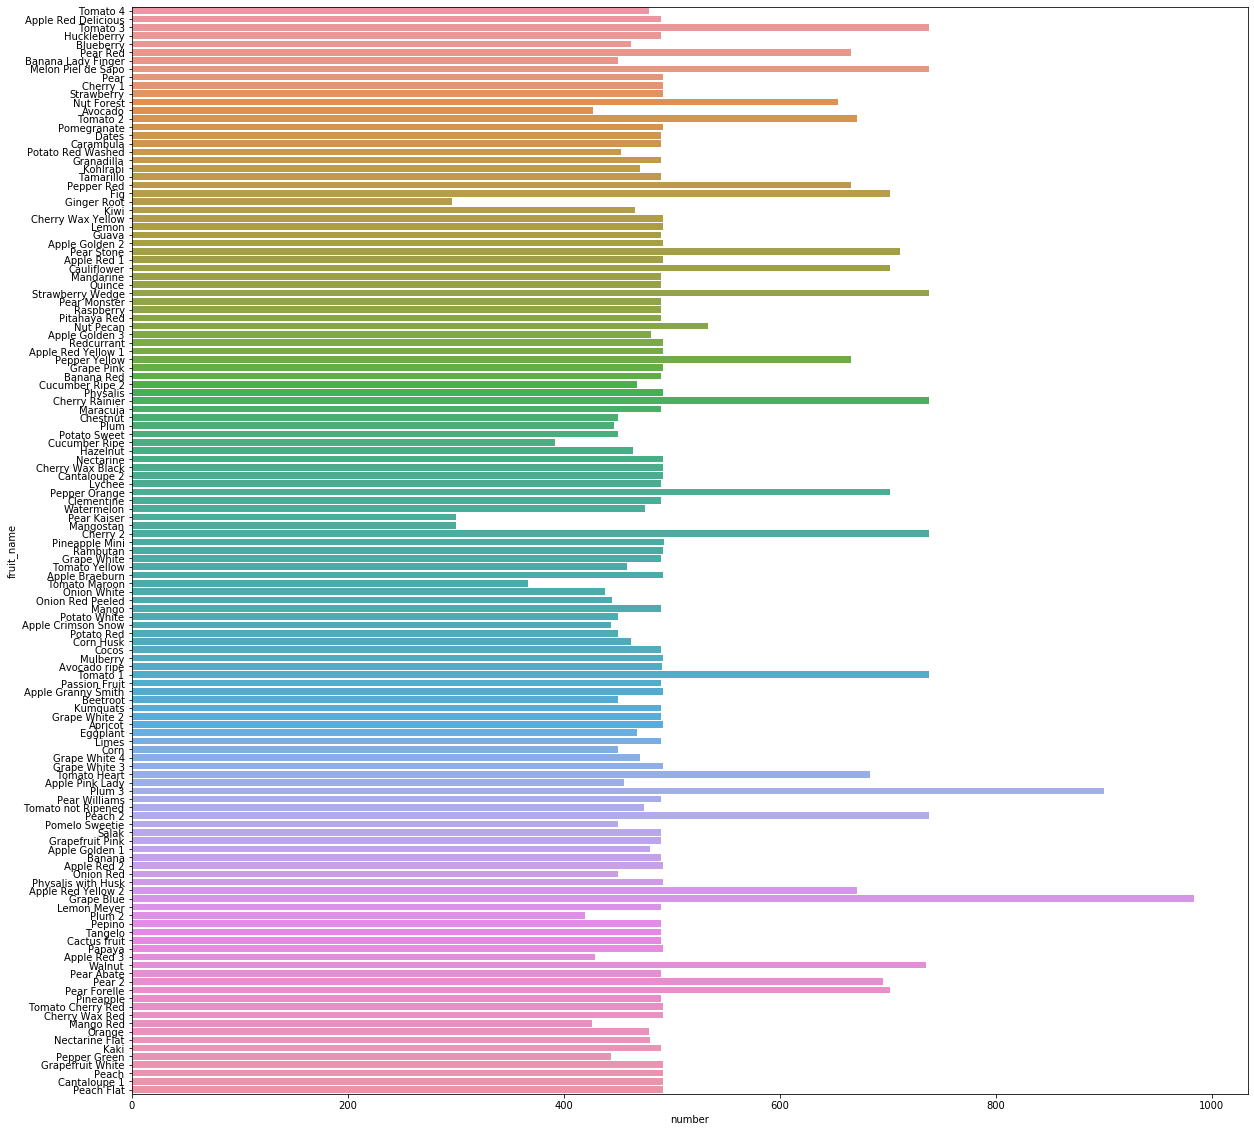

In [45]:
f, ax = plt.subplots(figsize=(20,20))
sns.barplot(x='number', y='fruit_name', data=data)

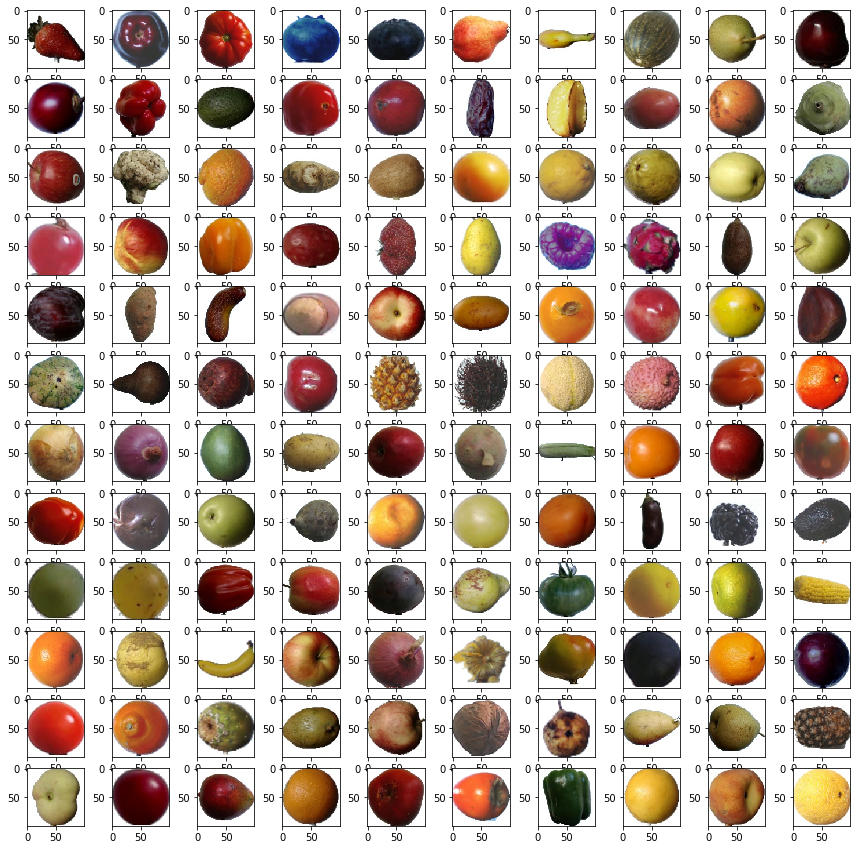

In [48]:
categories = list(new_dic.keys())
f, ax = plt.subplots(12,10, figsize=(15, 15)) # 11 hàng, mỗi hàng 10 biểu đồ
i = 0
for category in categories:
  path= os.path.join(train_path, category) # đường dẫn đến các folder là label
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # để hiện màu trên jupyter notebook
    ax[i//11,i%10].imshow(img_array) # tính toán cho khớp với 11 hàng 10 cột
    i+=1
    break # chỉ vẽ 1 hình đầu tiên rồi break
plt.show()

In [50]:
# create larger_model
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(100, 100, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(131, activation='softmax'))
    # compile model
    lrate= 0.01
    decay= lrate/25
    sgd = SGD(lr=lrate, momentum=0.9, decay = decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = larger_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)       

In [61]:
# fit model
batch_size = 256
model.fit_generator(generator=train_set, verbose=1,
                   steps_per_epoch= train_set.samples//batch_size,
                   epochs=10)

Epoch 1/10
264/264 [==============================] - 1155s 4s/step - loss: 3.4722 - accuracy: 0.1716
Epoch 2/10
264/264 [==============================] - 1126s 4s/step - loss: 0.8752 - accuracy: 0.7304
Epoch 3/10
264/264 [==============================] - 1181s 4s/step - loss: 0.2247 - accuracy: 0.9264
Epoch 4/10
264/264 [==============================] - 1180s 4s/step - loss: 0.1038 - accuracy: 0.9662
Epoch 5/10
264/264 [==============================] - 1142s 4s/step - loss: 0.0579 - accuracy: 0.9809
Epoch 6/10
264/264 [==============================] - 1135s 4s/step - loss: 0.0402 - accuracy: 0.9868
Epoch 7/10
264/264 [==============================] - 1117s 4s/step - loss: 0.0273 - accuracy: 0.9908
Epoch 8/10
264/264 [==============================] - 1119s 4s/step - loss: 0.0205 - accuracy: 0.9929
Epoch 9/10
264/264 [==============================] - 1118s 4s/step - loss: 0.0148 - accuracy: 0.9950
Epoch 10/10
264/264 [==============================] - 1118s 4s/step - loss: 0.014

In [63]:
# evaluate model
loss = model.evaluate_generator(generator=test_set, steps=test_set.samples//batch_size)
print('Accuracy: %.2f' % (loss[1]*100))

Accuracy: 92.46


In [65]:
batch_size = 64
y_true_array = np.array([]) # initial array
y_pred_array = np.array([]) # initial array
for i in range(test_set.samples//batch_size):

    X_test, y_test = next(test_set)
    predicted_y = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(predicted_y, axis=1)
    y_true_array = np.append(y_true_array, y_true)
    y_pred_array = np.append(y_pred_array, y_pred)

In [67]:
result = classification_report(y_true=y_true_array, y_pred=y_pred_array)
print(result)

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.76       654
         1.0       1.00      0.99      1.00       591
         2.0       1.00      0.65      0.79       637
         3.0       0.92      0.93      0.92       656
         4.0       0.96      1.00      0.98       643
         5.0       1.00      1.00      1.00       654
         6.0       0.78      0.96      0.86       602
         7.0       1.00      0.70      0.82       656
         8.0       0.92      0.96      0.94       651
         9.0       0.90      1.00      0.95       569
        10.0       0.94      1.00      0.97       660
        11.0       1.00      0.72      0.84       653
        12.0       0.96      1.00      0.98       874
        13.0       0.84      1.00      0.91       654
        14.0       0.83      1.00      0.91       570
        15.0       0.94      1.00      0.97       661
        16.0       0.64      0.25      0.36       660
        17.0       0.42    

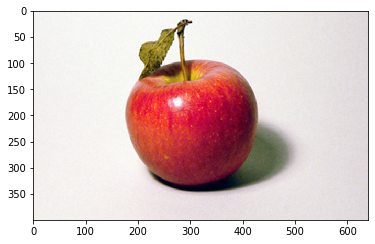

In [68]:
img = cv2.imread('apple.jpg',1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [69]:
new_img = cv2.resize(img, (100,100)) #resize
new_img= new_img.reshape(1, 100 , 100, 3)
new_img.shape

(1, 100, 100, 3)

In [70]:
predicted = model.predict(new_img)
print(predicted)
predicted = np.argmax(predicted)
print(predicted)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
24


In [71]:
mydict = test_set.class_indices
print(list(mydict.keys())[list(mydict.values()).index(predicted)])

Carambula
